## Import libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test

## Read simulation files

In [39]:
## Read random baseline simulation results
df_sim_random = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_random_baseline_simulation.csv')
df_sim_random.head()

,participant_id,actual_days,model_intrusive_pings,projected_days,v_model,reduction_rate
0,ambushdollhousegenerous@timestudy_com,100.0,767.04,124.895703,7.670400,0.2
1,anywaymustinesspushiness@timestudy_com,16.0,26.36,20.030349,1.647500,0.2
2,bottledeskworkrequire@timestudy_com,111.0,529.06,138.891619,4.766306,0.2
3,browsingfrisbeepersevere@timestudy_com,78.0,611.82,97.528685,7.843846,0.2
4,buckedstiflestagnant@timestudy_com,207.0,1315.36,258.561154,6.354396,0.2


In [40]:
## Read s1 threshold simulation results
df_sim1_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup1.csv')
df_sim1_thresholds.head()

,participant_id,threshold,f1,actual_days,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,0.521739,100.0,365.00,265.00,9.5800,2.0200,1
1,anywaymustinesspushiness@timestudy_com,33,0.135922,16.0,27.79,11.79,2.0625,1.1875,0
2,bottledeskworkrequire@timestudy_com,662,0.383971,111.0,215.49,104.49,5.9640,3.0721,0
3,browsingfrisbeepersevere@timestudy_com,765,0.509105,78.0,365.00,287.00,9.8077,1.5641,1
4,buckedstiflestagnant@timestudy_com,1643,0.522926,207.0,365.00,158.00,7.9372,3.0338,1


In [41]:
## Read s2 threshold simulation results
df_sim2_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup2.csv')
df_sim2_thresholds.head()

,participant_id,threshold,actual_days,f1,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,100.0,0.448617,365.0,265.0,9.5800,0.7400,1
1,anywaymustinesspushiness@timestudy_com,33,16.0,0.137313,52.8,36.8,2.0625,0.6250,0
2,bottledeskworkrequire@timestudy_com,662,111.0,0.366062,365.0,254.0,5.9640,1.5135,1
3,browsingfrisbeepersevere@timestudy_com,765,78.0,0.473062,365.0,287.0,9.8077,0.5769,1
4,buckedstiflestagnant@timestudy_com,1643,207.0,0.472386,365.0,158.0,7.9372,1.3671,1


## Survival analysis

In [42]:
def prepare_survival_dataframe(df_random, df_s1, df_s2):
    """
    Combines simulation results into a long-format DataFrame for statistical testing.
    The 'Actual (Lazy)' group is derived from the 'actual_days' column of the models.
    """
    data_list = []
    
    # 1. First, create the 'Actual (Lazy)' group using Ground Truth (actual_days)
    # We can pull this from any of the three dataframes as it is consistent across all.
    actual_df = pd.DataFrame({
        'duration': df_s1['actual_days'],
        'group': 'Actual (Lazy)',
        # For the withdrawn group, these are all observed events (they actually quit)
        'event': (df_s1['actual_days'] < 365.0).astype(int)
    })
    data_list.append(actual_df)

    # 2. Add the Simulated results (projected_days)
    mapping = {
        'Random (20% Block)': df_random,
        'Setup 1': df_s1,
        'Setup 2': df_s2
    }
    
    for label, df in mapping.items():
        temp_df = pd.DataFrame({
            'duration': df['projected_days'],
            'group': label,
            # Observed = 0 if they survive to 365 (Censored), else 1 (Event)
            'event': (df['projected_days'] < 365.0).astype(int)
        })
        data_list.append(temp_df)
    
    return pd.concat(data_list, ignore_index=True)

In [43]:
df_survival_master = prepare_survival_dataframe(df_sim_random, df_sim1_thresholds, df_sim2_thresholds)

In [44]:
def run_statistical_tests(df_long):
    """
    Performs Omnibus Log-Rank test followed by Pairwise Post-Hoc comparisons.
    """
    print("\n" + "="*60)
    print("      SURVIVAL STATISTICS: OMNIBUS & POST-HOC")
    print("="*60)

    # 1. Omnibus Test (Multivariate Log-Rank)
    results_omnibus = multivariate_logrank_test(
        df_long['duration'], 
        df_long['group'], 
        df_long['event']
    )
    
    print(f"OMNIBUS LOG-RANK TEST")
    print(f"p-value: {results_omnibus.p_value:.2e}")
    print(f"Test Statistic: {results_omnibus.test_statistic:.4f}")
    
    if results_omnibus.p_value < 0.05:
        print("\nRESULT: Significant difference detected between groups.")
        print("Proceeding to Pairwise Post-Hoc comparisons...")
        
        # 2. Pairwise Post-Hoc (Log-Rank)
        results_pairwise = pairwise_logrank_test(
            df_long['duration'], 
            df_long['group'], 
            df_long['event']
        )
        
        print("\nPAIRWISE LOG-RANK SUMMARY:")
        print(results_pairwise.summary[['test_statistic', 'p', '-log2(p)']])
    else:
        print("\nRESULT: No significant difference detected across groups.")

    print("="*60 + "\n")

In [49]:
run_statistical_tests(df_survival_master)


      SURVIVAL STATISTICS: OMNIBUS & POST-HOC
OMNIBUS LOG-RANK TEST
p-value: 1.31e-26
Test Statistic: 123.5734

RESULT: Significant difference detected between groups.
Proceeding to Pairwise Post-Hoc comparisons...

PAIRWISE LOG-RANK SUMMARY:
                                       test_statistic             p   -log2(p)
Actual (Lazy)      Random (20% Block)        3.940635  4.713299e-02   4.407119
                   Setup 1                  56.897803  4.590584e-14  44.308316
                   Setup 2                  81.296871  1.942339e-19  62.158839
Random (20% Block) Setup 1                  37.063377  1.143514e-09  29.703879
                   Setup 2                  61.222204  5.098330e-15  47.478897
Setup 1            Setup 2                   5.816453  1.587693e-02   5.976924



In [89]:
def plot_survival_curves(df_long):
    """
    Generates a high-quality Kaplan-Meier plot with all four conditions.
    Legend will have white background and black text.
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    kmf = KaplanMeierFitter()
    
    styles = {
        'Actual (Lazy)': {'color': 'black', 'ls': '--', 'alpha': 0.9},
        'Random (20% Block)': {'color': 'red', 'ls': ':', 'alpha': 0.8},
        'Setup 1': {'color': 'royalblue', 'ls': '-', 'alpha': 1.0},
        'Setup 2': {'color': 'forestgreen', 'ls': '-', 'alpha': 1.0}
    }

    for group_name in ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']:
        if group_name not in df_long['group'].unique():
            continue
        mask = df_long['group'] == group_name
        kmf.fit(
            durations=df_long.loc[mask, 'duration'],
            event_observed=df_long.loc[mask, 'event'],
            label=group_name
        )
        kmf.plot_survival_function(
            ax=ax,
            ci_show=True,
            color=styles[group_name]['color'],
            linestyle=styles[group_name]['ls'],
            alpha=styles[group_name]['alpha'],
            lw=3.0 if 'Setup' in group_name else 2.0
        )

    # Formatting
    ax.set_title("Counterfactual Survival Analysis: Impact of Intelligent Burden Reduction",
                 fontsize=16, fontweight='bold', pad=18)
    ax.set_xlabel("Days in Study (Observation Period)", fontsize=13)
    ax.set_ylabel("Probability of Participant Retention", fontsize=13)
    ax.set_ylim(0, 1.02)
    ax.set_xlim(0, 370)
    ax.axvline(365, color='red', linestyle='--', alpha=0.35, label='Study End (Day 365)')

    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(which='major', linestyle='-', alpha=0.15)

    # Legend with white background and black text
    leg = ax.legend(loc='lower left', fontsize=11, frameon=True)
    if leg is not None:
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(1.0)
        for txt in leg.get_texts():
            txt.set_color('black')
        try:
            leg.get_title().set_color('black')
        except Exception:
            pass

    sns.despine(ax=ax, offset=8, trim=False)
    plt.tight_layout()
    plt.show()

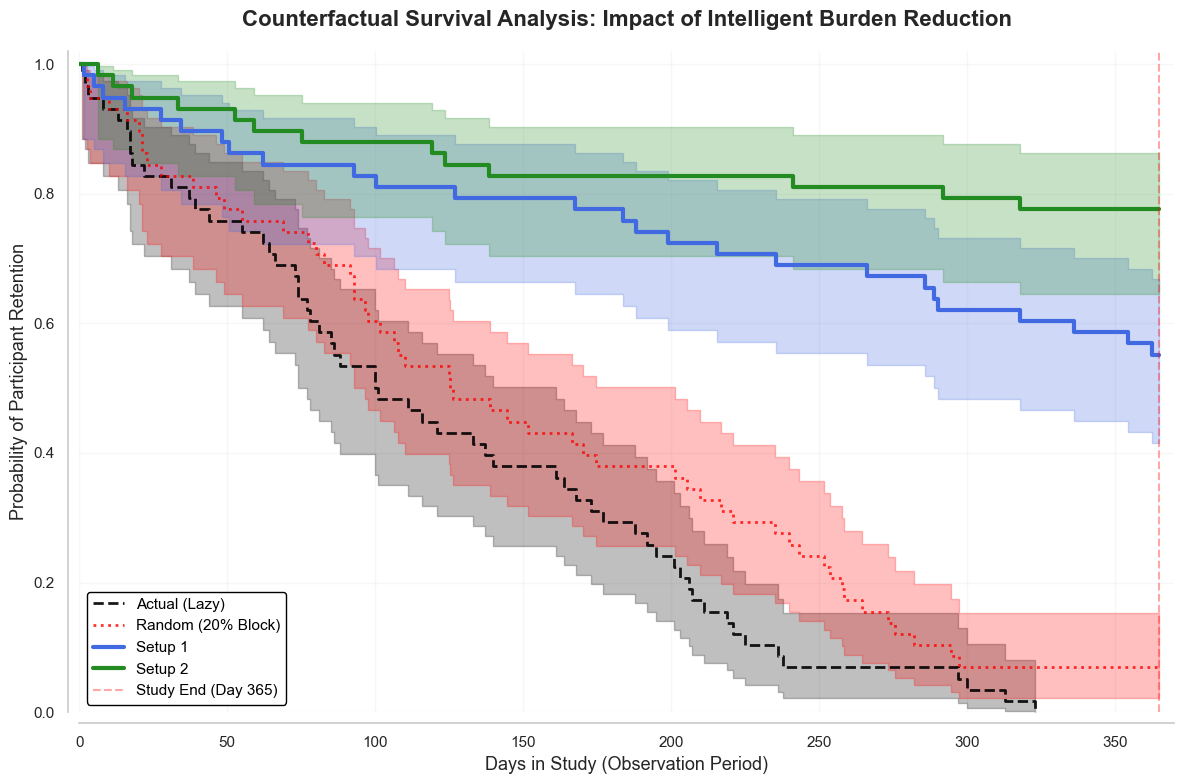

In [90]:
plot_survival_curves(df_survival_master)

In [52]:
def plot_retention_distributions(df_long):
    """
    Generates a 2x2 grid of density plots for each condition,
    highlighting the mean with a dashed line and text label on the line.
    All subplots share the same x and y axes for comparability.
    """
    # Define order and palette
    order = ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']
    palette = {
        'Actual (Lazy)': 'black',
        'Random (20% Block)': 'red',
        'Setup 1': 'royalblue',
        'Setup 2': 'forestgreen'
    }

    # Added sharey=True to ensure uniform y-axis scaling across the grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, group in enumerate(order):
        ax = axes[i]
        if group not in df_long['group'].unique():
            continue
            
        data = df_long[df_long['group'] == group]['duration']
        mean_val = data.mean()
        
        # Plot Density
        sns.kdeplot(
            data=data, 
            ax=ax,
            color=palette[group],
            fill=True,
            alpha=0.3,
            linewidth=2,
            bw_adjust=0.5
        )
        
        # Highlight mean with a dashed line
        ax.axvline(x=mean_val, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Write mean on the line
        # Use a relative position based on the current axis view
        y_limit = ax.get_ylim()[1]
        ax.text(
            mean_val + 2, 
            y_limit * 0.7, 
            f'Mean: {mean_val:.1f}d', 
            color='black', 
            fontweight='bold',
            rotation=0,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )

        # Study End Reference
        ax.axvline(365, color='red', linestyle='-', alpha=0.2)
        
        # Subplot Formatting
        ax.set_title(f"Condition: {group}", fontsize=13, fontweight='bold')
        ax.set_ylabel("Density" if i % 2 == 0 else "")
        ax.set_xlabel("Days in Study" if i >= 2 else "")
        ax.set_xlim(0, 400)
        ax.grid(True, linestyle=':', alpha=0.4)

    plt.suptitle("Retention Density Distribution Analysis", fontsize=17, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

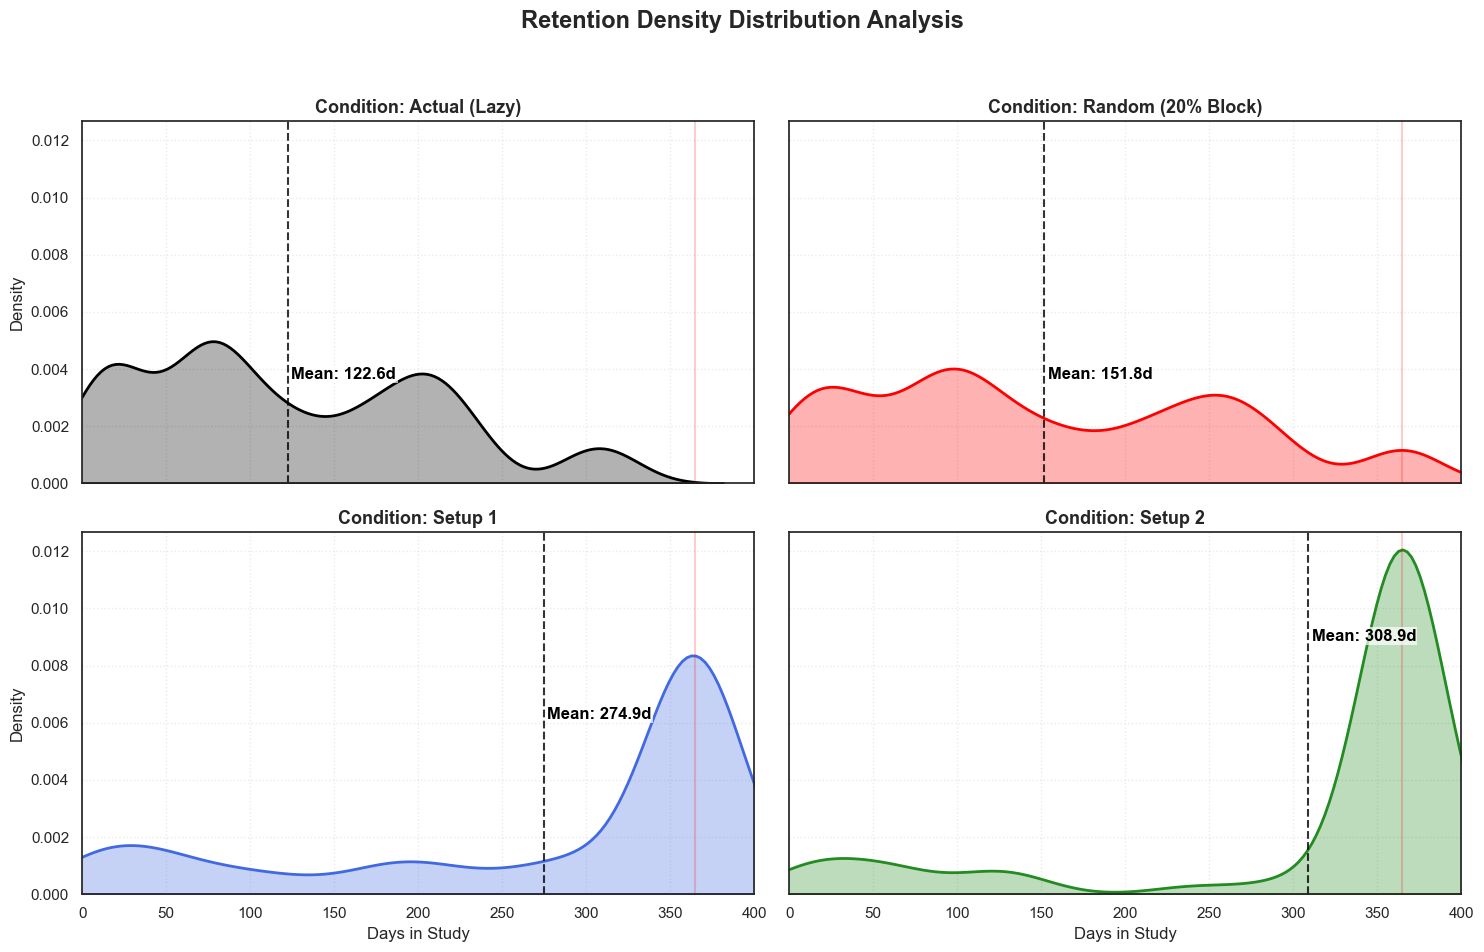

In [53]:
plot_retention_distributions(df_survival_master)

## Paired samples t-test for f1 scores

In [58]:
from scipy import stats

def compare_model_performance(df_s1, df_s2):
    """
    Performs a paired samples t-test and calculates Cohen's d for effect size.
    
    Args:
        df_s1: DataFrame for Setup 1 with columns ['participant_id', 'f1_score_c0']
        df_s2: DataFrame for Setup 2 with columns ['participant_id', 'f1_score_c0']
    """
    # 1. Merge the dataframes on participant_id to ensure paired alignment
    # We use inner join to ensure we only compare users present in both evaluations
    df_comp = pd.merge(
        df_s1[['participant_id', 'f1']], 
        df_s2[['participant_id', 'f1']], 
        on='participant_id', 
        suffixes=('_s1', '_s2')
    )

    if len(df_comp) < 2:
        print("Error: Not enough overlapping participants to perform a paired t-test.")
        return

    s1_scores = df_comp['f1_s1']
    s2_scores = df_comp['f1_s2']

    # 2. Perform Paired Samples T-Test
    # H0: There is no difference in mean F1 score between Setup 1 and Setup 2
    t_stat, p_val = stats.ttest_rel(s2_scores, s1_scores)

    # 3. Calculate Cohen's d for Paired Samples
    # Formula: Mean of differences / Standard Deviation of differences
    diffs = s2_scores - s1_scores
    cohen_d = np.mean(diffs) / np.std(diffs, ddof=1)

    # 4. Display Results
    print("\n" + "="*60)
    print("      STATISTICAL COMPARISON: SETUP 1 vs SETUP 2 (F1)")
    print("="*60)
    print(f"Number of Participants (N):  {len(df_comp)}")
    print(f"Setup 1 Mean F1 (Class 0):   {s1_scores.mean():.4f}")
    print(f"Setup 2 Mean F1 (Class 0):   {s2_scores.mean():.4f}")
    print(f"Mean Difference:             {np.mean(diffs):+.4f}")
    print("-" * 60)
    print(f"T-statistic:                 {t_stat:.4f}")
    print(f"P-value:                     {p_val:.2e}")
    print(f"Cohen's d (Effect Size):      {cohen_d:.4f}")
    print("-" * 60)

    # Interpretation
    if p_val < 0.05:
        verdict = "Statistically Significant"
        direction = "Setup 2 improved performance." if np.mean(diffs) > 0 else "Setup 1 performed better."
    else:
        verdict = "Not Statistically Significant"
        direction = "The performance difference is likely due to chance."

    print(f"VERDICT: {verdict}")
    print(f"INTERPRETATION: {direction}")
    
    # Cohen's d guidance
    if abs(cohen_d) < 0.2: effect = "Negligible"
    elif abs(cohen_d) < 0.5: effect = "Small"
    elif abs(cohen_d) < 0.8: effect = "Medium"
    else: effect = "Large"
    
    print(f"EFFECT MAGNITUDE: {effect}")
    print("="*60 + "\n")

    return df_comp

In [59]:
comparison_df = compare_model_performance(df_sim1_thresholds, df_sim2_thresholds)


      STATISTICAL COMPARISON: SETUP 1 vs SETUP 2 (F1)
Number of Participants (N):  58
Setup 1 Mean F1 (Class 0):   0.4258
Setup 2 Mean F1 (Class 0):   0.4078
Mean Difference:             -0.0179
------------------------------------------------------------
T-statistic:                 -3.4012
P-value:                     1.23e-03
Cohen's d (Effect Size):      -0.4466
------------------------------------------------------------
VERDICT: Statistically Significant
INTERPRETATION: Setup 1 performed better.
EFFECT MAGNITUDE: Small



In [ ]:
def plot_f1_violin(df_sim1_threshold, df_sim2_threshold, fcol='f1', labels=('Depth Model','Breadth Model'), figsize=(6,4), baseline=0.20, palette=None):
    """Create and return a violin plot comparing F1 distributions for two models.

    Args:
        df_sim1_threshold (pd.DataFrame or pd.Series): source for model 1; must contain `fcol`.
        df_sim2_threshold (pd.DataFrame or pd.Series): source for model 2; must contain `fcol`.
        fcol (str): column name holding f1 scores (default 'f1').
        labels (tuple): x-axis labels for the two models.
        figsize (tuple): figure size.
        baseline (float): horizontal baseline to draw and annotate.
        palette: seaborn palette or list of colors.

    Returns:
        Matplotlib Figure and Axes: (fig, ax)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    order = ['Depth Model', 'Breadth Model']
    palette = {
        'Depth Model': 'royalblue',
        'Breadth Model': 'forestgreen'
    }
    # Extract series
    def _extract(series_like):
        if isinstance(series_like, pd.DataFrame):
            if fcol not in series_like.columns:
                raise ValueError(f"DataFrame missing column '{fcol}'")
            return series_like[fcol].dropna().astype(float)
        elif isinstance(series_like, pd.Series):
            return series_like.dropna().astype(float)
        else:
            # try to convert
            return pd.Series(series_like).dropna().astype(float)

    s1 = _extract(df_sim1_threshold)
    s2 = _extract(df_sim2_threshold)

    if s1.empty and s2.empty:
        raise ValueError('Both input series are empty after dropping NaNs')

    data = pd.concat([
        pd.DataFrame({'model': labels[0], 'f1': s1.values}),
        pd.DataFrame({'model': labels[1], 'f1': s2.values})
    ], ignore_index=True)

    fig, ax = plt.subplots(figsize=figsize)
    pal = palette if palette is not None else ["C0", "C1"]

    sns.violinplot(x='model', y='f1', data=data, ax=ax, inner='quartile', 
                   palette=pal, alpha=0.5, cut = 0)

    # horizontal baseline and annotation
    ax.axhline(baseline, color='red', linestyle='--', linewidth=1.25)
    # place annotated text centered above the line
    # ax.text(0.5, baseline + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
    #         f'Random baseline = {baseline:.2f}', color='red', ha='center', va='bottom', transform=ax.get_xaxis_transform())
    y_text = baseline + 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.annotate(
        f'Random baseline = {baseline:.2f}',
        xy=(0.5, baseline),
        xytext=(0.90, y_text),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        arrowprops=dict(arrowstyle='->', color='black', lw=1, connectionstyle="arc3,rad=.2")
    )

    ax.set_xlabel('Model')
    ax.set_ylabel('F1 score')
    ax.set_title('F1 distribution: Depth Model vs Breadth Model')
    return fig, ax


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_43726/1993149834.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='model', y='f1', data=data, ax=ax, inner='quartile',


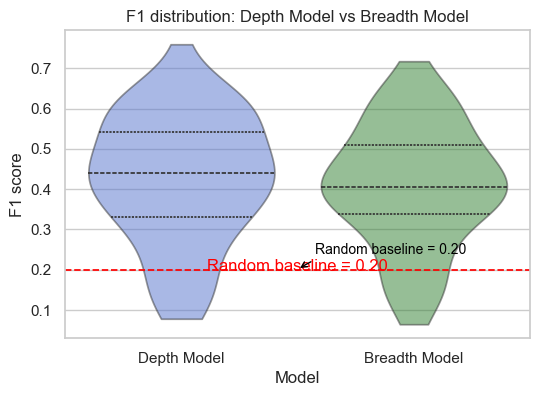

In [131]:
fig, ax = plot_f1_violin(df_sim1_thresholds, df_sim2_thresholds, fcol='f1')
# fig.savefig('/Users/f1_violin.png')

## Compare held out performance

In [68]:
## Read generalized model f1 scores
df_generalized = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/general_f1_scores.csv')
df_generalized.head()

,participant_id,f1_score_c0
0,animateshowerclothes@timestudy_com,0.241637
1,atlanticchefhatchet@timestudy_com,0.521287
2,beavertomatoupscale@timestudy_com,0.353380
3,bondingcoasterdirtiness@timestudy_com,0.590871
4,childhoodmovingmagnify@timestudy_com,0.219321


In [69]:
## rename columns for consistency
df_generalized.rename(columns={'f1_score_c0':'f1_score', 'participant_id':'participant_id'}, inplace=True)

In [70]:
df_generalized.head()

,participant_id,f1_score
0,animateshowerclothes@timestudy_com,0.241637
1,atlanticchefhatchet@timestudy_com,0.521287
2,beavertomatoupscale@timestudy_com,0.353380
3,bondingcoasterdirtiness@timestudy_com,0.590871
4,childhoodmovingmagnify@timestudy_com,0.219321


In [63]:
## Read hybrid model f1 scores
df_hybrid = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/hybrid_f1_scores.csv')
df_hybrid.head()

,participant_id,f1_score
0,animateshowerclothes@timestudy_com,0.169373
1,atlanticchefhatchet@timestudy_com,0.721534
2,beavertomatoupscale@timestudy_com,0.446813
3,bondingcoasterdirtiness@timestudy_com,0.563272
4,childhoodmovingmagnify@timestudy_com,0.501453


### Plot distributions

In [126]:
def plot_f1_violin_generalized_hybrid(df_generalized, df_hybrid, fcol='f1_score', labels=('Depth Model','Breadth Model'), figsize=(6,4), baseline=0.20, palette=None):
    """Create and return a violin plot comparing `f1_score` for generalized vs hybrid.

    Args:
        df_generalized, df_hybrid: DataFrame/Series containing `fcol`.
        fcol: column name (default 'f1_score').
        labels: tuple of x-axis labels.
        baseline: horizontal baseline value to draw and annotate.

    Returns:
        (fig, ax)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    order = ['Depth Model', 'Breadth Model']
    palette = {
        'Depth Model': 'royalblue',
        'Breadth Model': 'forestgreen'
    }

    def _extract(series_like):
        if isinstance(series_like, pd.DataFrame):
            if fcol not in series_like.columns:
                raise ValueError(f"DataFrame missing column '{fcol}'")
            return series_like[fcol].dropna().astype(float)
        elif isinstance(series_like, pd.Series):
            return series_like.dropna().astype(float)
        else:
            return pd.Series(series_like).dropna().astype(float)

    s1 = _extract(df_generalized)
    s2 = _extract(df_hybrid)

    if s1.empty and s2.empty:
        raise ValueError('Both input series are empty after dropping NaNs')

    data = pd.concat([
        pd.DataFrame({'model': labels[0], 'f1': s1.values}),
        pd.DataFrame({'model': labels[1], 'f1': s2.values})
    ], ignore_index=True)

    fig, ax = plt.subplots(figsize=figsize)
    pal = palette if palette is not None else ["C0", "C1"]
    sns.violinplot(x='model', y='f1', data=data, ax=ax, inner='quartile', palette=pal, 
                   linewidth = 1.5, edgecolor='black', alpha=0.5, cut=0)

    # horizontal baseline and annotation with arrow
    ax.axhline(baseline, color='red', linestyle='--', linewidth=1.0)
    # ensure consistent y-limits for annotation placement
    ax.set_ylim(0, 1)
    y_text = baseline + 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    # smaller text with arrow pointing to the red baseline
    ax.annotate(
        f'Random baseline = {baseline:.2f}',
        xy=(0.5, baseline),
        xytext=(0.90, y_text),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        arrowprops=dict(arrowstyle='->', color='black', lw=1, connectionstyle="arc3,rad=.2")
    )

    ax.set_xlabel('Model')
    ax.set_ylabel('F1 score')
    ax.set_title('F1 distribution: Generalized vs Hybrid')
    return fig, ax


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_43726/2417004299.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='model', y='f1', data=data, ax=ax, inner='quartile', palette=pal,


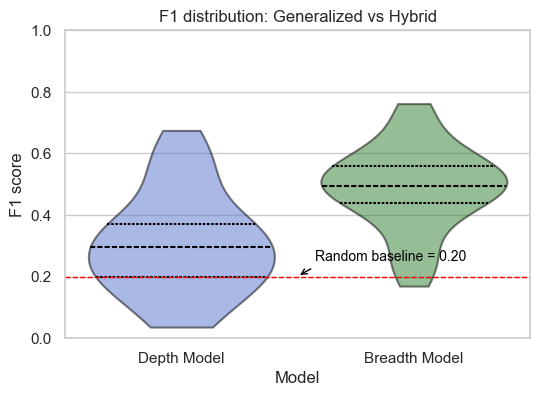

In [127]:
fig, ax = plot_f1_violin_generalized_hybrid(df_generalized, df_hybrid, fcol='f1_score')
# fig.savefig('f1_violin_generalized_hybrid.png')

In [125]:
## Get minimum f1 score across both models
print(df_generalized['f1_score'].min())
print(df_hybrid['f1_score'].min())

0.0363636363636363
0.1693725318121983


### Paired sampled t-test

In [73]:
def paired_ttest_f1(df_generalized, df_hybrid, fcol='f1_score', alpha=0.05):
    """Perform a paired-samples t-test on `fcol` between two inputs.

    Returns a dict with: t_stat, df, p_value, mean_diff, 95% CI tuple, cohens_d, n
    Pairing strategy:
      - If both inputs have overlapping indices, pairs are matched by index.
      - Otherwise pairs are matched by position after dropping NaNs; length uses the smaller series.
    """
    import numpy as np
    import pandas as pd
    try:
        from scipy import stats
    except Exception:
        raise ImportError('scipy is required for paired_ttest_f1')

    def _extract(x):
        if isinstance(x, pd.DataFrame):
            if fcol not in x.columns:
                raise ValueError(f"DataFrame missing column '{fcol}'")
            return x[fcol].astype(float)
        elif isinstance(x, pd.Series):
            return x.astype(float)
        else:
            return pd.Series(x).astype(float)

    s1 = _extract(df_generalized)
    s2 = _extract(df_hybrid)

    # Try to pair by common index
    common_idx = s1.index.intersection(s2.index)
    if len(common_idx) > 0:
        a = s1.loc[common_idx]
        b = s2.loc[common_idx]
        mask = a.notna() & b.notna()
        a = a[mask]; b = b[mask]
    else:
        # fallback to positional pairing after dropping NaNs
        a = s1.dropna().reset_index(drop=True)
        b = s2.dropna().reset_index(drop=True)
        nmin = min(len(a), len(b))
        a = a.iloc[:nmin]
        b = b.iloc[:nmin]

    n = len(a)
    if n < 2:
        raise ValueError('Not enough paired observations for t-test (need >=2)')

    diff = (a.values - b.values).astype(float)
    mean_diff = diff.mean()
    sd_diff = diff.std(ddof=1)
    se = sd_diff / np.sqrt(n)
    dfree = n - 1

    t_stat = mean_diff / se
    p_value = stats.t.sf(abs(t_stat), dfree) * 2

    t_crit = stats.t.ppf(1 - alpha/2, dfree)
    ci_low = mean_diff - t_crit * se
    ci_high = mean_diff + t_crit * se

    cohens_d = mean_diff / sd_diff if sd_diff != 0 else np.nan

    return {
        't_stat': float(t_stat),
        'df': int(dfree),
        'p_value': float(p_value),
        'mean_diff': float(mean_diff),
        '95%_CI': (float(ci_low), float(ci_high)),
        'cohens_d': float(cohens_d) if pd.notna(cohens_d) else np.nan,
        'n': int(n)
    }


In [74]:
res = paired_ttest_f1(df_generalized, df_hybrid, fcol='f1_score')
print(res)

{'t_stat': -8.912639430772652, 'df': 35, 'p_value': 1.5755945523732786e-10, 'mean_diff': -0.1788091624708608, '95%_CI': (-0.2195380510560494, -0.13808027388567218), 'cohens_d': -1.4854399051287752, 'n': 36}


## Get hazard ratios for survival analysis

In [95]:
def compute_hazard_ratios(df_long):
    """
    Computes Hazard Ratios (HR) using Cox Proportional Hazards Regression.
    Uses the summary table for robust extraction of exponentiated coefficients and CIs.
    
    Args:
        df_long: The long-format DataFrame containing 'duration', 'group', and 'event'.
    """
    print("\n" + "="*60)
    print("      HAZARD RATIO ANALYSIS (Effect Size)")
    print("="*60)

    # Define the specific pairwise comparisons to perform (Target vs Reference)
    comparisons = [
        ('Random (20% Block)', 'Actual (Lazy)'),
        ('Setup 1', 'Actual (Lazy)'),
        ('Setup 2', 'Actual (Lazy)'),
        ('Setup 2', 'Setup 1') # Added head-to-head comparison
    ]
    
    hr_results = []

    for target, reference in comparisons:
        # Filter data for the specific pair comparison
        pair_df = df_long[df_long['group'].isin([reference, target])].copy()
        
        # Convert group to a binary variable: 
        # 0 for the reference group, 1 for the target group
        pair_df['is_target'] = (pair_df['group'] == target).astype(int)
        
        # Initialize and fit Cox Model
        cph = CoxPHFitter()
        # We pass only the columns relevant for the model to the fit function
        cph.fit(pair_df[['duration', 'event', 'is_target']], 
                duration_col='duration', 
                event_col='event')
        
        # --- ROBUST EXTRACTION USING SUMMARY TABLE ---
        # The summary table contains pre-calculated exp(coef) and its CI bounds
        summary = cph.summary
        
        hr = summary.loc['is_target', 'exp(coef)']
        lower_ci = summary.loc['is_target', 'exp(coef) lower 95%']
        upper_ci = summary.loc['is_target', 'exp(coef) upper 95%']
        p_val = summary.loc['is_target', 'p']

        hr_results.append({
            'Comparison': f"{target} vs {reference}",
            'Hazard Ratio': hr,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci,
            'p-value': p_val
        })

    # Display Results
    df_hr = pd.DataFrame(hr_results)
    print(df_hr.to_string(index=False, formatters={
        'Hazard Ratio': '{:,.3f}'.format,
        '95% CI Lower': '{:,.3f}'.format,
        '95% CI Upper': '{:,.3f}'.format,
        'p-value': '{:,.2e}'.format
    }))
    
    print("-" * 60)
    print("INTERPRETATION GUIDE:")
    print("HR < 1.0: Target group has a lower risk (hazard) of withdrawal than Reference.")
    print("HR = 0.30: 70% reduction in the hazard of quitting compared to reference.")
    print("Example: Setup 2 vs Setup 1 HR = 0.75 means 25% lower risk for Setup 2.")
    print("="*60 + "\n")
    
    return df_hr

In [96]:
df_hr_summary = compute_hazard_ratios(df_survival_master)


      HAZARD RATIO ANALYSIS (Effect Size)
                         Comparison Hazard Ratio 95% CI Lower 95% CI Upper  p-value
Random (20% Block) vs Actual (Lazy)        0.684        0.470        0.997 4.80e-02
           Setup 1 vs Actual (Lazy)        0.160        0.095        0.271 7.55e-12
           Setup 2 vs Actual (Lazy)        0.078        0.040        0.151 4.09e-14
                 Setup 2 vs Setup 1        0.450        0.231        0.876 1.88e-02
------------------------------------------------------------
INTERPRETATION GUIDE:
HR < 1.0: Target group has a lower risk (hazard) of withdrawal than Reference.
HR = 0.30: 70% reduction in the hazard of quitting compared to reference.
Example: Setup 2 vs Setup 1 HR = 0.75 means 25% lower risk for Setup 2.

